In [1]:
import glob
import pytorch_lightning as pl
import torch 
from pytorch_lightning.metrics.functional.classification import accuracy
from tqdm import tqdm
from src import DataModule, Model
import skimage.io as io

In [3]:
models = glob.glob('seresnext*-fold_*.ckpt')
models

['seresnext50_32x4d-256-fold_1-val_acc=0.87525.ckpt',
 'seresnext50_32x4d-256-fold_2-val_acc=0.87415.ckpt',
 'seresnext50_32x4d-256-fold_3-val_acc=0.87544.ckpt',
 'seresnext50_32x4d-256-fold_4-val_acc=0.87985.ckpt',
 'seresnext50_32x4d-256-fold_5-val_acc=0.88688.ckpt']

In [13]:
path = './data'
path_images = '/extra/test/0'
images = os.listdir(f'{path}/{path_images}')
images_paths = [f'{path_images}/{img}' for img in images]
len(images_paths)

3774

In [14]:
path_images = '/extra/extraimages'
images = os.listdir(f'{path}/{path_images}')
images_paths += [f'{path_images}/{img}' for img in images]
len(images_paths)

16369

In [15]:
import cv2
import skimage.io as io

class Dataset(torch.utils.data.Dataset):
    def __init__(self, path, imgs, trans=None):
        self.path = path
        self.imgs = imgs
        self.trans = trans

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, ix):
        img = cv2.imread(f'{self.path}/{self.imgs[ix]}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.trans:
            img = self.trans(image=img)['image']
        img = torch.tensor(img, dtype=torch.float).permute(2,0,1)
        return img

In [16]:
import albumentations as A
trans = A.Compose([
    #A.PadIfNeeded(256,256),
    A.RandomCrop(256,256),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Normalize()
])
dataset = Dataset(path, images_paths, trans)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)

In [17]:
 def predict(models, dl, tta = 1):  
    final_preds = []
    for ix, model in enumerate(models):
        print(f"model {ix+1}")
        model = Model.load_from_checkpoint(checkpoint_path=model)
        model.eval()
        model.cuda()
        tta_preds = []
        for i in range(tta):
            print(f"tta round {i+1}")
            preds = torch.tensor([]).cuda()
            with torch.no_grad():
                t = tqdm(dl)
                for b, x in enumerate(t):
                    x = x.cuda()
                    y_hat = model(x)
                    preds = torch.cat([preds, y_hat])
            tta_preds.append(preds)
        tta_preds = torch.stack(tta_preds).mean(axis=0)
        final_preds.append(tta_preds)
    final_preds = torch.stack(final_preds).mean(axis=0)
    probas = torch.softmax(final_preds, axis=1)
    return probas.max(1)

In [18]:
probas, preds = predict(models, dataloader, tta=5)

model 1


  0%|                                                                                | 0/128 [00:00<?, ?it/s]

tta round 1


100%|██████████████████████████████████████████████████████████████████████| 128/128 [03:17<00:00,  1.54s/it]


model 2


  0%|                                                                                | 0/128 [00:00<?, ?it/s]

tta round 1


100%|██████████████████████████████████████████████████████████████████████| 128/128 [01:51<00:00,  1.15it/s]


model 3


  0%|                                                                                | 0/128 [00:00<?, ?it/s]

tta round 1


100%|██████████████████████████████████████████████████████████████████████| 128/128 [01:52<00:00,  1.14it/s]


model 4


  0%|                                                                                | 0/128 [00:00<?, ?it/s]

tta round 1


100%|██████████████████████████████████████████████████████████████████████| 128/128 [01:51<00:00,  1.15it/s]


model 5


  0%|                                                                                | 0/128 [00:00<?, ?it/s]

tta round 1


100%|██████████████████████████████████████████████████████████████████████| 128/128 [01:50<00:00,  1.16it/s]


In [24]:
#data_pseudo = pd.DataFrame({'image_id': images_paths, 'label': preds.cpu().numpy(), 'probas': probas.cpu().numpy() })
data_pseudo = pd.read_csv('./data/data_pseudo.csv')
data_pseudo

,image_id,label,probas
0,/extra/test/0/test-img-0.jpg,1,0.948925
1,/extra/test/0/test-img-1.jpg,1,0.827620
2,/extra/test/0/test-img-10.jpg,3,0.957109
3,/extra/test/0/test-img-100.jpg,2,0.930944
4,/extra/test/0/test-img-1000.jpg,1,0.985332
...,...,...,...
16364,/extra/extraimages/extra-image-9992.jpg,3,0.463383
16365,/extra/extraimages/extra-image-9993.jpg,2,0.895335
16366,/extra/extraimages/extra-image-9995.jpg,3,0.988225
16367,/extra/extraimages/extra-image-9996.jpg,3,0.992323


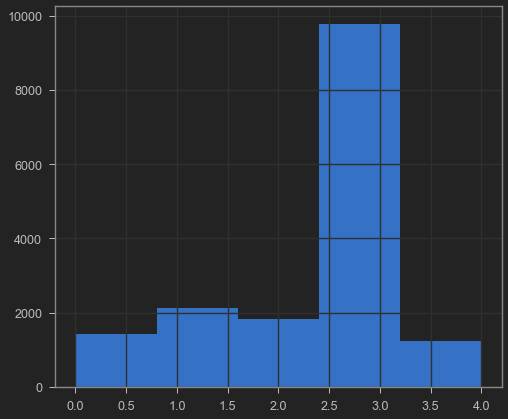

In [21]:
data_pseudo.label.hist(bins=5)

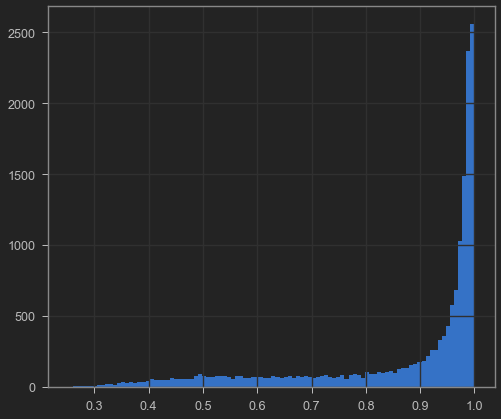

In [22]:
data_pseudo.probas.hist(bins=100)

In [23]:
data_pseudo.to_csv('./data/data_pseudo.csv', index=False)

In [25]:
data_extra = pd.read_csv('./data/train_extra.csv')

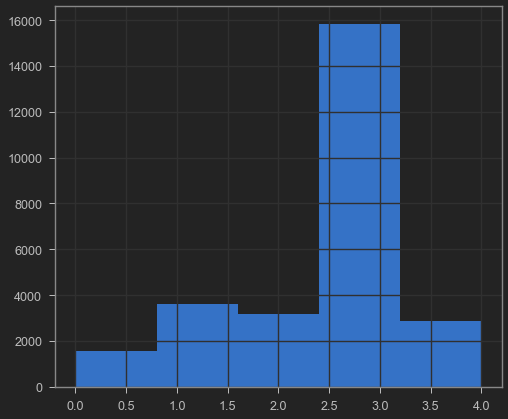

In [26]:
data_extra.label.hist(bins=5)

In [52]:
data_pseudo_filtered = data_pseudo[(data_pseudo.probas > 0.8) & (data_pseudo.label != 3)][['image_id', 'label']]
#data_pseudo_filtered = data_pseudo[data_pseudo.probas > 0.95][['image_id', 'label']]
data_pseudo_filtered

,image_id,label
0,/extra/test/0/test-img-0.jpg,1
1,/extra/test/0/test-img-1.jpg,1
3,/extra/test/0/test-img-100.jpg,2
4,/extra/test/0/test-img-1000.jpg,1
9,/extra/test/0/test-img-1005.jpg,2
...,...,...
16356,/extra/extraimages/extra-image-9982.jpg,2
16359,/extra/extraimages/extra-image-9987.jpg,0
16362,/extra/extraimages/extra-image-999.jpg,0
16365,/extra/extraimages/extra-image-9993.jpg,2


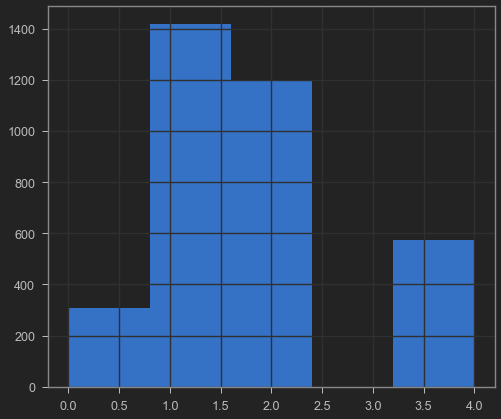

In [53]:
data_pseudo_filtered.label.hist(bins=5)

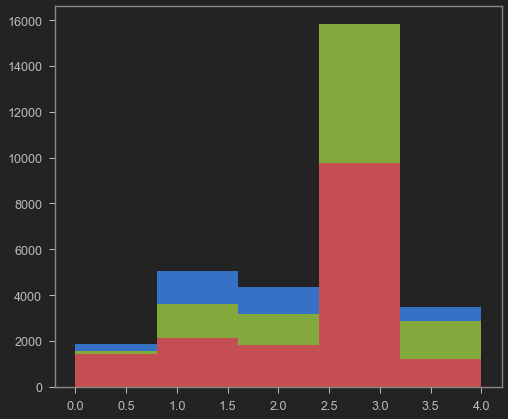

In [45]:
data_extra_pseudo = pd.concat([data_extra, data_pseudo_filtered])

plt.hist(data_extra_pseudo.label, bins=5)
plt.hist(data_extra.label, bins=5)
plt.hist(data_pseudo.label, bins=5)
plt.show()

In [46]:
data_extra_pseudo.to_csv('./data/data_extra_pseudo.csv', index=False)

In [47]:
data_extra_train = pd.read_csv('./data/data_extra_train.csv')
data_extra_pseudo_train = pd.concat([data_extra_train, data_pseudo_filtered])
data_extra_pseudo_train

,image_id,label
0,train_images/3228239886.jpg,0
1,train_images/3241038013.jpg,3
2,train_images/2661420264.jpg,3
3,train_images/4192933342.jpg,3
4,train_images/4245562546.jpg,3
...,...,...
16356,/extra/extraimages/extra-image-9982.jpg,2
16359,/extra/extraimages/extra-image-9987.jpg,0
16362,/extra/extraimages/extra-image-999.jpg,0
16365,/extra/extraimages/extra-image-9993.jpg,2


In [48]:
data_extra_pseudo_train.to_csv('./data/data_extra_pseudo_train.csv', index=False)

In [49]:
data_extra_pseudo_val = pd.read_csv('./data/data_extra_val.csv')
data_extra_pseudo_val.to_csv('./data/data_extra_pseudo_val.csv', index=False)